In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.legend_handler import HandlerTuple
from matplotlib.container import Container
import pandas as pd
import numpy as np
import os, requests, tarfile, zipfile, io
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u, io
# from style import output_folder, big_fontsize, base_width, base_height, dpi
import seaborn as sns
import json
from astropy.time import Time
from style import *
from LC import candidates_lc_dir, get_lc, names

In [2]:
disc_time = Time('2020-08-15 08:06:00.000').jd

In [3]:
def plot_lc(name, sigma=5):
    
    jdass, jdice, data, nu_name, ttype = get_lc(name)
    fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)
    conts = list()
    labels = list()
    for band, d in data.items():
        
        if 'corrupted' in band:
            continue
        
#         m = np.array([i in corrupted for i in d.IMAGE])
#         d = d[~m]
        
        jd = d['JD'] - jdass
        mag = d['mag']
        err = d['mag_err']
        
        if len(jd):
            errm = (d['flux(mJy)'] < d.flux_err * sigma) | (err == 99.99)
#             cont1 = ax.errorbar(jd[~errm], mag[~errm], yerr=err[~errm], color=bandcols[band], ls='',
#                         markeredgecolor='k', ecolor='k', markersize=3, capsize=2, marker=bandmark[band], mew=0.5, elinewidth=0.5)
            cont1 = ax.errorbar(jd[~errm], mag[~errm], yerr=err[~errm], color=bandcols[band], marker=bandmark[band], **lc_errbar_kw)
#             cont2,  = ax.plot(jd[errm], mag[errm], marker='v', color=bandcols[band], ls='', markersize=2, 
#                                  mfc=None, markeredgecolor=bandcols[band], mew=0.5, fillstyle='none', zorder=0)
            cont2,  = ax.plot(jd[errm], mag[errm], color=bandcols[band], markeredgecolor=bandcols[band], **lc_uplim_kw)
            conts.append((cont1, cont2))
            labels.append(f"{band}, upper limits")

    ylim = ax.get_ylim()
    ax.set_ylim([ylim[1], ylim[0]])
    ax.set_ylabel('magnitude')
    mjd_ass = Time(jdass[0], format='jd').mjd
    mjd_ice = Time(jdice[0], format='jd').mjd
    ax.set_xlabel(f'MJD - {mjd_ass:.0f}')
    line = ax.axvline(mjd_ice-mjd_ass)
    ax.legend([line] + conts, [nu_name] + labels, handler_map={tuple: HandlerTuple(ndivide=None)})
    ax.set_title(name)
    fig.tight_layout()
    return fig, ax

In [4]:
tab = io.ascii.read('data/at2020rng_ztffps.txt')
names = list(tab[0])
names[6] ='info'
names = [i.strip(',') for i in names]
tab = io.ascii.read('data/at2020rng_ztffps.txt', names=names)[1:]
t = np.array(tab['jd']).astype(float)

In [5]:
min(abs(t - disc_time))

3.4700147807598114e-05

In [6]:
det = tab[np.argmin(abs(t - disc_time))]
fdet = float(det['forcediffimflux'])
func = float(det['forcediffimfluxunc'])
detmag = float(det['zpdiff']) - 2.5*np.log10(fdet)
print(detmag, fdet/func, det['programid'], det['filter'], det['nearestrefmag'], det['dnearestrefsrc'], det['nearestrefsharp'])

16.784695535673357 14.507115229947985 1 ZTF_r 15.4939998626709 0.211280122804579 0.296999990940094


In [7]:
sum(tab['procstatus'] == '56')

8

In [8]:
sum(~(tab['forcediffimflux'] == 'null'))

1019

In [9]:
tab = tab[tab['programid'] == '1']
tab = tab[~(tab['forcediffimflux'] == 'null')]

In [10]:
jdass, jdice, data, nu_name, ttype = get_lc('AT2020rng')
f = np.array(tab['forcediffimflux']).astype(float)
fu = np.array(tab['forcediffimfluxunc']).astype(float)
zp = np.array(tab['zpdiff']).astype(float)
t = np.array(tab['jd']).astype(float) - jdass
fltr = tab['filter']

# m = f/fu > 0
# tab = tab[m]

mag = zp[m] - 2.5*np.log10(f[m])
mage = 1.0857* fu[m] / f[m]

no data for AT2020rng for V


NameError: name 'm' is not defined

In [11]:
def get_ztffps_at2020rng():
    tab = io.ascii.read('data/at2020rng_ztffps.txt')
    names = list(tab[0])
    names[6] ='info'
    names = [i.strip(',') for i in names]
    tab = io.ascii.read('data/at2020rng_ztffps.txt', names=names)[1:]
    tab = tab[tab['programid'] == '1']
    tab = tab[~(tab['forcediffimflux'] == 'null')]

    jdass, jdice, data, nu_name, ttype = get_lc('AT2020rng')
    f = np.array(tab['forcediffimflux']).astype(float)
    fu = np.array(tab['forcediffimfluxunc']).astype(float)
    zp = np.array(tab['zpdiff']).astype(float)
    t = np.array(tab['jd']).astype(float) - jdass
    fltr = tab['filter']

    m = f/fu > 5
    print(f"{sum(m)} detections")
    tab = tab

    mag = np.zeros(len(tab))
    mage = np.zeros(len(tab))
    
    mag[m] = zp[m] - 2.5*np.log10(f[m])
    mage[m] = 1.0857* fu[m] / f[m]
    
    mag[~m] = zp[~m] - 2.5 * np.log10(5 * fu[~m])
    mage[~m] = 99.99
    
    return t, mag, mage, fltr

In [12]:
t, m, em, f = get_ztffps_at2020rng()

no data for AT2020rng for V
13 detections


In [13]:
jdass

array([2459089.9])

In [14]:
ztfdat = pd.DataFrame({f'JD - {jdass[0]:.1f}': t, 'JD': t+jdass, 'mag': m, 'emag': em, 'filter': f})
ztfdat[(ztfdat['JD - 2459089.9'] > -15) & (ztfdat['JD - 2459089.9'] < 0)]


,JD - 2459089.9,JD,mag,emag,filter
66,-14.990451,2.459075e+06,17.808170,99.990000,ZTF_r
67,-14.069491,2.459076e+06,20.903979,99.990000,ZTF_r
68,-14.048692,2.459076e+06,21.035093,99.990000,ZTF_g
69,-14.013426,2.459076e+06,21.075864,99.990000,ZTF_g
70,-13.062465,2.459077e+06,16.784696,0.074839,ZTF_r
71,-12.038113,2.459078e+06,21.115463,99.990000,ZTF_g
72,-11.092917,2.459079e+06,20.306288,0.132422,ZTF_r
73,-11.063449,2.459079e+06,20.971868,99.990000,ZTF_r
74,-11.038738,2.459079e+06,21.147123,99.990000,ZTF_g
75,-11.008391,2.459079e+06,19.995195,99.990000,ZTF_g


In [129]:
ztfdat.loc[68:72].to_csv('data/at2020rng_around_discovery.csv', index=False)

In [123]:
ztfdat.columns

Index(['JD - 2459089.9', 'JD', 'mag', 'emag', 'filter'], dtype='object')

In [85]:
f

ZTF_r
ZTF_r
ZTF_r
ZTF_g
ZTF_r
ZTF_r
ZTF_r
ZTF_r
ZTF_r
ZTF_r
ZTF_r


no data for AT2020rng for V
no data for AT2020rng for V
13 detections
no data for AT2020rng for V


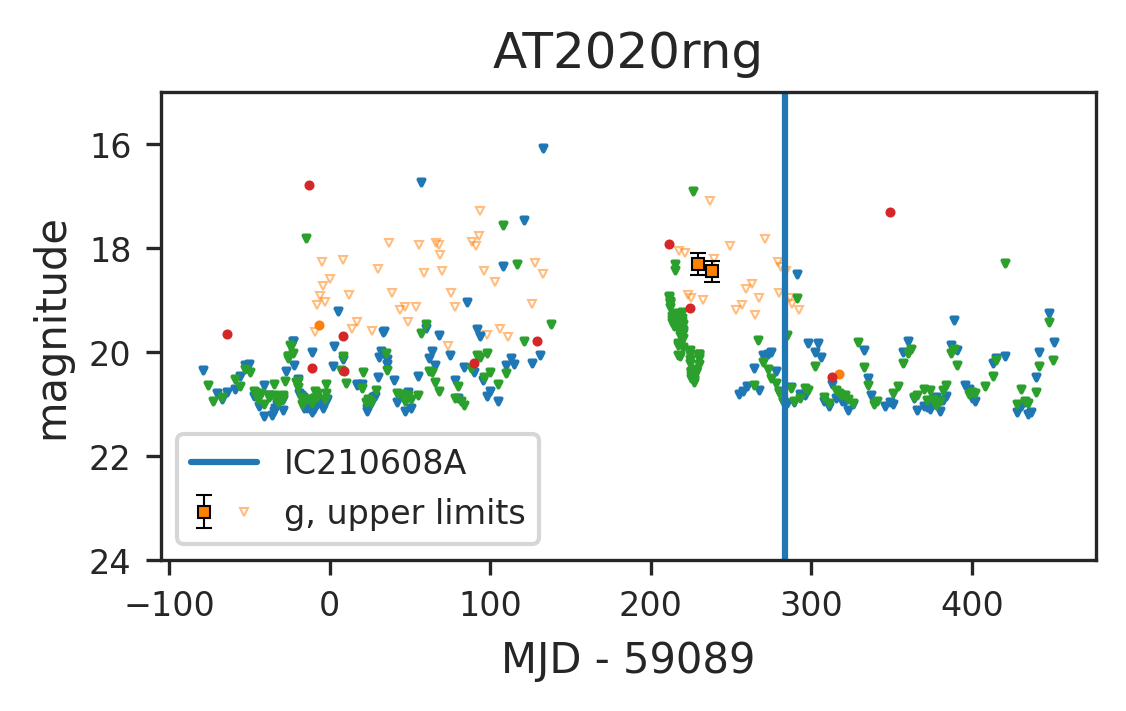

In [15]:
jdass, jdice, data, nu_name, ttype = get_lc('AT2020rng')
ztft, ztfmag, ztfmage, ztfftr = get_ztffps_at2020rng()

fig, ax = plot_lc('AT2020rng')
for f in np.unique(ztfftr):
    fm = ztfftr == f
    
    for ul in [True, False]:
        if ul:
            ulm = ztfmage == 99.99
            marker = 'v'
        else:
            ulm = ztfmage != 99.99
            marker = 'o'
            
        ax.scatter(ztft[fm & ulm], ztfmag[fm & ulm], s=2, marker=marker)
        
ax.set_ylim([24, 15])
plt.show()
plt.close()

In [63]:
ztfmag

array([24.9682433 , 19.11545799, 16.78469554, 20.30628846, 21.47643245,
       21.13785326, 19.46824767, 24.12837073, 22.49506941, 20.53560281,
       19.68395112, 21.5075193 , 20.36970007, 22.5631997 , 23.15063365,
       21.44935464, 22.15705419, 23.00331962, 21.48481887, 22.46797247,
       26.45294691, 21.5501651 , 20.90222463])

In [2]:
aperture_phot = pd.read_csv('data/LC/at2020rng_aperture_phot.csv')

In [13]:
aperture_phot_g = aperture_phot[aperture_phot.Filter == 'g']
aperture_phot_g_det = aperture_phot_g[aperture_phot_g.mag_err != 99.990]

In [18]:
aperture_phot_g_det.mag.astype(float).mean()

15.29197972972973